In [22]:
from tokenize import endpats

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.4.0
0.19.0


In [66]:
device = str('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [4]:
import os
from pathlib import Path
train_data = datasets.FashionMNIST(#root=os.path.abspath("/tmp/pycharm_project_286/data")
                                   root="data", 
                                   train=True, 
                                   transform=ToTensor(), 
                                   download=True,
                                   target_transform=None)

In [11]:
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  transform=ToTensor(),
                                  download=True,
                                  target_transform=None)


In [16]:
len(train_data), len(test_data)
train_data.class_to_idx
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

Text(0.5, 1.0, '9')

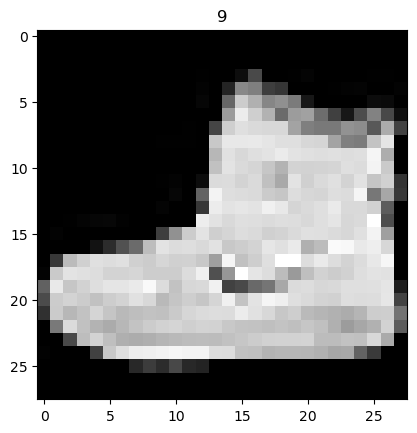

In [28]:
image,label = train_data[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(label)

In [32]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader, test_dataloader    

(<torch.utils.data.dataloader.DataLoader at 0x7fa864206200>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa8641e8bb0>)

In [25]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [50]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_shape: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_shape),
            #nn.ReLU(),
            nn.Linear(hidden_shape, output_shape),
            #nn.ReLU()
        )
    def forward(self,x):
        return self.layer_stack(x) 

In [34]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape= 28*28,
                              hidden_shape= 10,
                              output_shape= len(train_data.classes)).to(device)



In [35]:
from helper_function import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [90]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start   
    print(f"Total time on {device}: {total_time:.3f} seconds")
    return total_time

In [91]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss , train_acc = 0, 0
    model.train()
    for  X,y in data_loader:
        X, y = X.to(device), y.to(device)
    #for batch_idx, (X,y) in train_dataloader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Train loss: {(train_loss / len(data_loader)):.5f} | Train acc: {(train_acc / len(data_loader)):.5f} % on {device}")

In [95]:
def test_step(model: nn.Module,
              data_loader: DataLoader,
              accuracy_fn: nn.Module,
              device: torch.device = device):
    test_loss , test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        print(f"Test loss: {(test_loss / len(data_loader)):.5f} | Test acc: {(test_acc / len(data_loader)):.5f} % on {device}")        

In [96]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_step(model_0.to(device),train_dataloader,loss_fn,optimizer,accuracy_fn,device)
    test_step(model_0.to(device),test_dataloader,accuracy_fn,device)
train_time_end_on_gpu = timer()
print_train_time(train_time_start_on_gpu,train_time_end_on_gpu,device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.35156 | Train acc: 87.30833 % on cuda
Test loss: 0.44020 | Test acc: 84.89417 % on cuda
Epoch 1
Train loss: 0.35066 | Train acc: 87.45667 % on cuda
Test loss: 0.43248 | Test acc: 84.94409 % on cuda
Epoch 2
Train loss: 0.35048 | Train acc: 87.32000 % on cuda
Test loss: 0.43614 | Test acc: 84.94409 % on cuda
Epoch 3
Train loss: 0.34858 | Train acc: 87.46833 % on cuda
Test loss: 0.45309 | Test acc: 84.56470 % on cuda
Epoch 4
Train loss: 0.34947 | Train acc: 87.45333 % on cuda
Test loss: 0.44144 | Test acc: 84.52476 % on cuda
Epoch 5
Train loss: 0.34580 | Train acc: 87.54167 % on cuda
Test loss: 0.44778 | Test acc: 84.86422 % on cuda
Epoch 6
Train loss: 0.34418 | Train acc: 87.69333 % on cuda
Test loss: 0.43898 | Test acc: 84.68450 % on cuda
Epoch 7
Train loss: 0.34320 | Train acc: 87.49500 % on cuda
Test loss: 0.43510 | Test acc: 85.06390 % on cuda
Epoch 8
Train loss: 0.34249 | Train acc: 87.60500 % on cuda
Test loss: 0.43014 | Test acc: 85.04393 % on cuda
Epoch 9
Tr

64.95653141799994

In [72]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_loss = 0
    model_0.train()
    for batch_idx, (X,y) in enumerate(train_dataloader):
    #for batch_idx, (X,y) in train_dataloader:
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Looked at {batch_idx * len(X)} / {len(train_dataloader.dataset)} samples.")
        train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_pred=test_pred.argmax(dim=1), y_true=y_test)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

train_time_end_on_cpu = timer()
total_train_time = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Looked at 0 / 60000 samples.
Looked at 3200 / 60000 samples.
Looked at 6400 / 60000 samples.
Looked at 9600 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 16000 / 60000 samples.
Looked at 19200 / 60000 samples.
Looked at 22400 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 28800 / 60000 samples.
Looked at 32000 / 60000 samples.
Looked at 35200 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 41600 / 60000 samples.
Looked at 44800 / 60000 samples.
Looked at 48000 / 60000 samples.
Looked at 51200 / 60000 samples.
Looked at 54400 / 60000 samples.
Looked at 57600 / 60000 samples.

Train loss: 0.0001 | Test loss: 0.4416 | Test accuracy: 84.4449
Epoch 1
Looked at 0 / 60000 samples.
Looked at 3200 / 60000 samples.
Looked at 6400 / 60000 samples.
Looked at 9600 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 16000 / 60000 samples.
Looked at 19200 / 60000 samples.
Looked at 22400 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at

In [106]:
torch.manual_seed(42)
def eval_mode(model: torch.nn.Module,
              data_loader: DataLoader,
              loss_fn: torch.nn.CrossEntropyLoss,
              accuracy_fn,
              device: torch.device = device):
    loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            accuracy += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
        loss /= len(data_loader)
        accuracy /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_accuracy": accuracy}
model_0_result = eval_mode(model=model_0.to(device),
                           data_loader=train_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)

            

  0%|          | 0/1875 [00:00<?, ?it/s]

In [107]:
model_0_result

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.3239, device='cuda:0'),
 'model_accuracy': 88.355}